True reconstruction error: 1.9900


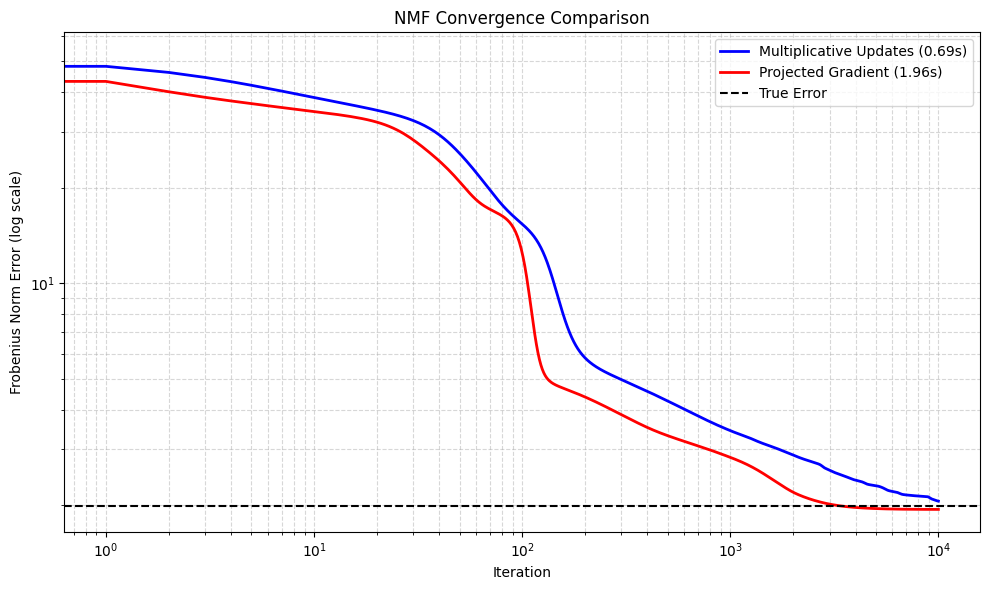


Algorithm Comparison:
Metric                    Multiplicative  Projected Gradient
Final Error               2.0613          1.9415         
Iterations                10000           10000          
Runtime (s)               0.6939          1.9596         


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Set random seed for reproducibility
np.random.seed(1917)

# 1. Generate synthetic data
def generate_synthetic_data(m=100, n=80, k=10, noise_level=0.1):
    """Generate synthetic non-negative matrix V = WH + noise"""
    # Ground truth matrices
    W_true = np.random.uniform(0, 1, size=(m, k))
    H_true = np.random.uniform(0, 1, size=(k, n))
    
    # Create clean data matrix
    V_clean = W_true @ H_true
    
    # Add Gaussian noise (clip to ensure non-negativity)
    noise = noise_level * np.random.randn(m, n)
    V = V_clean + noise
    V = np.clip(V, 0, None)  # Enforce non-negativity
    
    return V, W_true, H_true

# 2. Multiplicative Update Rules (Frobenius norm)
def nmf_multiplicative(V, k, max_iter=500, tol=1e-6, epsilon=1e-12):
    """NMF using Multiplicative Update Rules"""
    m, n = V.shape
    W = np.random.uniform(0, 1, size=(m, k))
    H = np.random.uniform(0, 1, size=(k, n))
    
    errors = []
    start_time = time()
    
    for i in range(max_iter):
        # Update H
        numerator_H = W.T @ V
        denominator_H = W.T @ W @ H + epsilon
        H *= numerator_H / denominator_H
        
        # Update W
        numerator_W = V @ H.T
        denominator_W = W @ H @ H.T + epsilon
        W *= numerator_W / denominator_W
        
        # Calculate reconstruction error
        error = np.linalg.norm(V - W @ H, 'fro')
        errors.append(error)
        
        # Check convergence
        if error < tol:
            break
    
    runtime = time() - start_time
    return W, H, errors, runtime

# 3. Projected Gradient Descent for ANLS
def nmf_projected_gradient(V, k, max_iter=500, tol=1e-6, 
                           step_size=0.01, beta=0.5, max_inner=20):
    """NMF using Projected Gradient Descent (ANLS)"""
    m, n = V.shape
    W = np.random.uniform(0, 1, size=(m, k))
    H = np.random.uniform(0, 1, size=(k, n))
    
    errors = []
    start_time = time()
    
    def project(X):
        """Project matrix onto non-negative orthant"""
        return np.clip(X, 0, None)
    
    def objective(W, H):
        """Calculate Frobenius norm objective"""
        return 0.5 * np.linalg.norm(V - W @ H, 'fro')**2
    
    def grad_W(W, H):
        """Gradient with respect to W"""
        return (W @ H - V) @ H.T
    
    def grad_H(W, H):
        """Gradient with respect to H"""
        return W.T @ (W @ H - V)
    
    for i in range(max_iter):
        # Optimize W with projected gradient
        for _ in range(max_inner):
            grad = grad_W(W, H)
            W_new = project(W - step_size * grad)
            
            # Simple backtracking line search
            if objective(W_new, H) < objective(W, H):
                W = W_new
                break
            else:
                step_size *= beta
        
        # Optimize H with projected gradient
        for _ in range(max_inner):
            grad = grad_H(W, H)
            H_new = project(H - step_size * grad)
            
            if objective(W, H_new) < objective(W, H):
                H = H_new
                break
            else:
                step_size *= beta
        
        # Calculate and store error
        error = np.linalg.norm(V - W @ H, 'fro')
        errors.append(error)
        
        # Check convergence
        if error < tol:
            break
    
    runtime = time() - start_time
    return W, H, errors, runtime

# 4. Generate synthetic data
V, W_true, H_true = generate_synthetic_data(m=200, n=200, k=5, noise_level=0.01)
true_error = np.linalg.norm(V - W_true @ H_true, 'fro')
print(f"True reconstruction error: {true_error:.4f}")

# 5. Run both algorithms
W_mul, H_mul, errors_mul, time_mul = nmf_multiplicative(V, k=5, max_iter=10_000)
W_pg, H_pg, errors_pg, time_pg = nmf_projected_gradient(V, k=5, max_iter=10_000)

# 6. Plot convergence
plt.figure(figsize=(10, 6))
# plt.semilogy(errors_mul, 'b-', linewidth=2, label=f'Multiplicative Updates ({time_mul:.2f}s)')
# plt.semilogy(errors_pg, 'r-', linewidth=2, label=f'Projected Gradient ({time_pg:.2f}s)')
plt.loglog(errors_mul, 'b-', linewidth=2, label=f'Multiplicative Updates ({time_mul:.2f}s)')
plt.loglog(errors_pg, 'r-', linewidth=2, label=f'Projected Gradient ({time_pg:.2f}s)')
plt.axhline(true_error, color='k', linestyle='--', label='True Error')

plt.title('NMF Convergence Comparison')
plt.xlabel('Iteration')
plt.ylabel('Frobenius Norm Error (log scale)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Print final results
print("\nAlgorithm Comparison:")
print(f"{'Metric':<25} {'Multiplicative':<15} {'Projected Gradient':<15}")
print(f"{'Final Error':<25} {errors_mul[-1]:<15.4f} {errors_pg[-1]:<15.4f}")
print(f"{'Iterations':<25} {len(errors_mul):<15} {len(errors_pg):<15}")
print(f"{'Runtime (s)':<25} {time_mul:<15.4f} {time_pg:<15.4f}")

In [1]:
p = 2/3
q = 1/3
1-2*p+q

5.551115123125783e-17

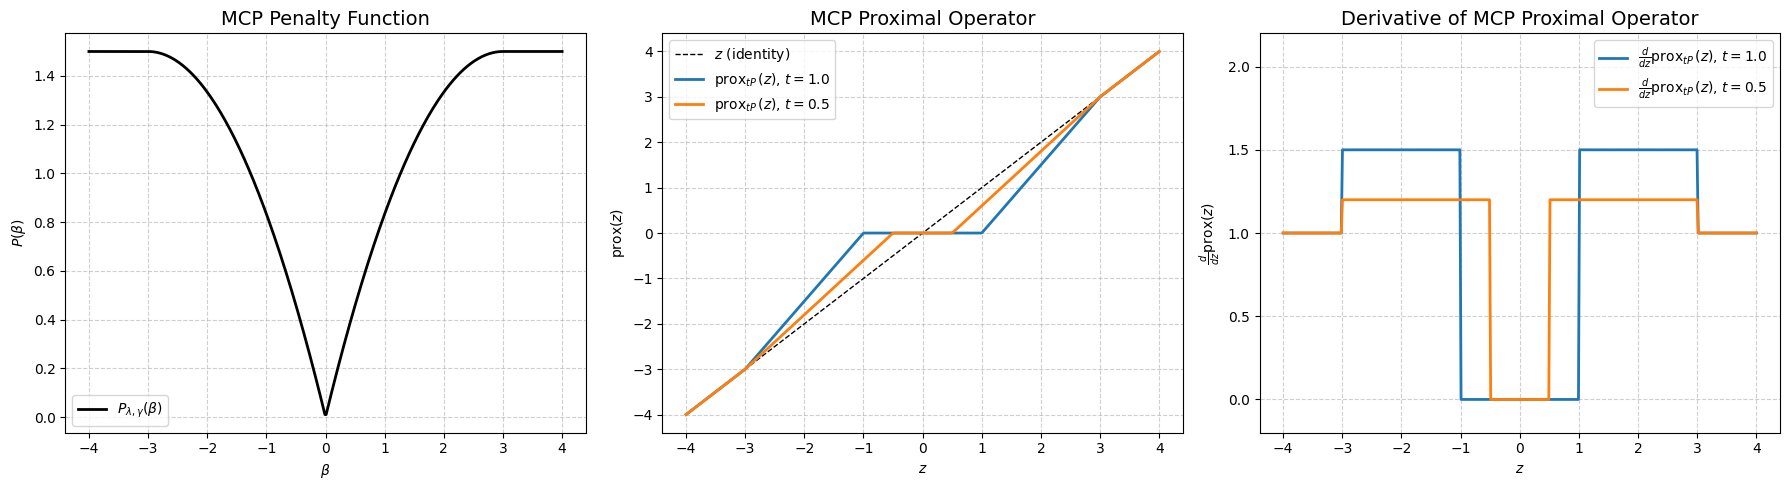

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---- MCP penalty function ----
def mcp_penalty(beta, lam, gamma):
    """MCP penalty P_{λ,γ}(β)"""
    beta = np.asarray(beta)
    p = np.zeros_like(beta, dtype=float)
    mask1 = np.abs(beta) <= gamma * lam
    mask2 = ~mask1
    # Region 1: |β| <= γλ
    p[mask1] = lam * np.abs(beta[mask1]) - (beta[mask1]**2) / (2 * gamma)
    # Region 2: |β| > γλ
    p[mask2] = 0.5 * gamma * lam**2
    return p

# ---- Proximal operator with general t ----
def prox_mcp_t(z, lam, gamma, t=1.0):
    if gamma <= t:
        raise ValueError("Require gamma > t for uniqueness.")
    z = np.asarray(z)
    beta = np.zeros_like(z, dtype=float)
    lower_thr = t * lam
    upper_thr = gamma * lam
    mask2 = (np.abs(z) > lower_thr) & (np.abs(z) <= upper_thr)
    mask3 = np.abs(z) > upper_thr
    soft = np.sign(z[mask2]) * (np.abs(z[mask2]) - lower_thr)
    beta[mask2] = soft / (1.0 - t / gamma)
    beta[mask3] = z[mask3]
    return beta

# ---- Gradient of proximal operator ----
def grad_prox_mcp_t(z, lam, gamma, t=1.0):
    if gamma <= t:
        raise ValueError("Require gamma > t.")
    z = np.asarray(z)
    g = np.zeros_like(z, dtype=float)
    lower_thr = t * lam
    upper_thr = gamma * lam
    mask2 = (np.abs(z) > lower_thr) & (np.abs(z) < upper_thr)
    mask3 = np.abs(z) > upper_thr
    g[mask2] = 1.0 / (1.0 - t / gamma)
    g[mask3] = 1.0
    return g

# ---- Parameters ----
lam = 1.0
gamma = 3.0
t_vals = [1.0, 0.5]

# Plot range
beta = np.linspace(-4, 4, 400)
z = np.linspace(-4, 4, 400)

# ---- Create subplots ----
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. MCP Penalty
axs[0].plot(beta, mcp_penalty(beta, lam, gamma), 'k-', linewidth=2, label=r'$P_{\lambda,\gamma}(\beta)$')
axs[0].set_title('MCP Penalty Function', fontsize=14)
axs[0].set_xlabel(r'$\beta$')
axs[0].set_ylabel(r'$P(\beta)$')
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend()

# 2. Proximal Operator
axs[1].plot(z, z, 'k--', linewidth=1, label=r'$z$ (identity)')
for t in t_vals:
    prox_vals = prox_mcp_t(z, lam, gamma, t=t)
    axs[1].plot(z, prox_vals, linewidth=2, label=rf'$\operatorname{{prox}}_{{tP}}(z)$, $t={t}$')
axs[1].set_title('MCP Proximal Operator', fontsize=14)
axs[1].set_xlabel(r'$z$')
axs[1].set_ylabel(r'$\operatorname{prox}(z)$')
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend()

# 3. Gradient of Proximal Operator
for t in t_vals:
    grad_vals = grad_prox_mcp_t(z, lam, gamma, t=t)
    axs[2].plot(z, grad_vals, linewidth=2, label=rf"$\frac{{d}}{{dz}}\operatorname{{prox}}_{{tP}}(z)$, $t={t}$")
axs[2].set_title('Derivative of MCP Proximal Operator', fontsize=14)
axs[2].set_xlabel(r'$z$')
axs[2].set_ylabel(r"$\frac{d}{dz}\operatorname{prox}(z)$")
axs[2].set_ylim(-0.2, 2.2)
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

jit = True
njit = njit if jit else lambda x : x

@njit
def mcp_penalty(beta, lam, gamma):
    beta = np.asarray(beta)
    p = np.zeros_like(beta, dtype=np.float64)
    mask = np.abs(beta) <= gamma * lam
    p[mask] = lam * np.abs(beta[mask]) - beta[mask]**2 / (2 * gamma)
    p[~mask] = 0.5 * gamma * lam**2
    return p

@njit
def prox_mcp_t(z, lam, gamma, t):
    if gamma <= t:
        raise ValueError("Need gamma > t")
    z = np.asarray(z)
    beta = np.zeros_like(z)
    lower = t * lam
    upper = gamma * lam
    mask2 = (np.abs(z) > lower) & (np.abs(z) <= upper)
    mask3 = np.abs(z) > upper
    soft = np.sign(z[mask2]) * (np.abs(z[mask2]) - lower)
    beta[mask2] = soft / (1 - t / gamma)
    beta[mask3] = z[mask3]
    return beta

@njit
def moreau_mcp(z, lam, gamma, t):
    """Moreau envelope of MCP: M_t P(z)"""
    beta_star = prox_mcp_t(z, lam, gamma, t)
    return mcp_penalty(beta_star, lam, gamma) + (z - beta_star)**2 / (2 * t)



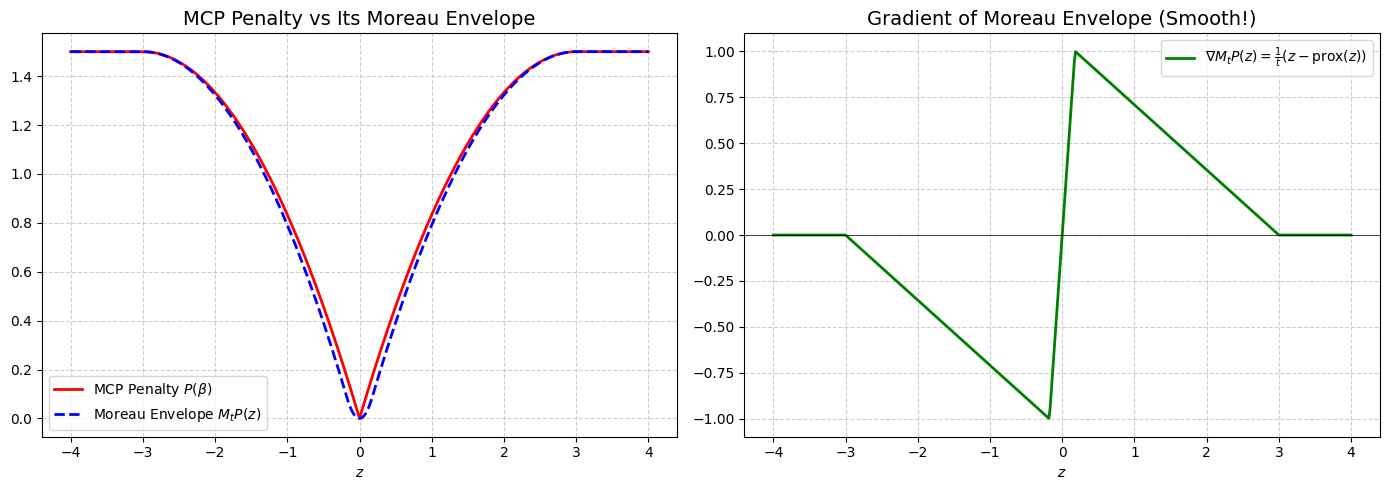

In [6]:
# Parameters
lam = 1.0
gamma = 3.0
# t = .5
t = 1000**(-1/4)

z = np.linspace(-4, 4, 500)

# Compute functions
mcp_vals = mcp_penalty(z, lam, gamma)
moreau_vals = moreau_mcp(z, lam, gamma, t)
grad_moreau = (z - prox_mcp_t(z, lam, gamma, t)) / t  # ∇M_t P(z)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left: MCP vs Moreau envelope
axs[0].plot(z, mcp_vals, 'r-', linewidth=2, label='MCP Penalty $P(\\beta)$')
axs[0].plot(z, moreau_vals, 'b--', linewidth=2, label='Moreau Envelope $M_t P(z)$')
axs[0].set_title('MCP Penalty vs Its Moreau Envelope', fontsize=14)
axs[0].set_xlabel('$z$')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.6)

# Right: Gradient of Moreau envelope
axs[1].plot(z, grad_moreau, 'g-', linewidth=2, label=r"$\nabla M_t P(z) = \frac{1}{t}(z - \mathrm{prox}(z))$")
axs[1].set_title('Gradient of Moreau Envelope (Smooth!)', fontsize=14)
axs[1].set_xlabel('$z$')
axs[1].axhline(0, color='k', linewidth=0.5)
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
from utils import prox_l1
x = [0, -1, 5]
prox_l1 (x, .1)

array([ 0. , -0.9,  4.9])

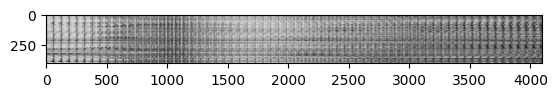

In [10]:
from BCD import load_dataset
import matplotlib.pyplot as plt
D = load_dataset('olivetti')
D.shape
plt.imshow(D, cmap='gray')

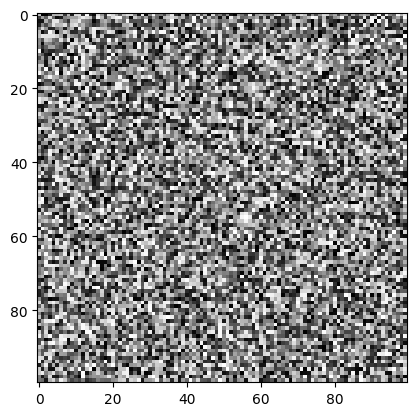

In [11]:
D = load_dataset('synthetic')
D.shape
plt.imshow(D, cmap='gray')


In [6]:
from functools import partial

import jax
import jax.numpy as jnp
import optax


def poly(x: jnp.ndarray, w: jnp.ndarray):
    assert w.shape == (3,)
    w = w.astype(jnp.float32)
    return w[0] * x + w[1] * x**3 + w[2] * x**5


def poly_chain(x: jnp.ndarray, w_seq: jnp.ndarray):
    y = [x]
    for w in w_seq:
        y.append(poly(y[-1], w))
    return y


def min_of_polys(x: jnp.ndarray, w_seq: jnp.ndarray):
    y = jnp.full_like(x, jnp.inf)
    for w in w_seq:
        y = jnp.minimum(y, poly(x, w))
    return y


@partial(jax.jit, static_argnums=(2, 3))
def optimize_w(
    w_seq: jnp.ndarray,
    lr: float,
    n: int,
    debug: bool = False,
):
    def loss(w_seq: jnp.ndarray):
        w_seq = w_seq.astype(jnp.bfloat16)
        xs = (jnp.arange(2048) + 1) / 2048
        *zs, ys = jax.vmap(poly_chain, in_axes=(0, None))(xs, w_seq)
        y_max = jnp.amax(ys)
        y_min = jnp.amin(jnp.where(xs > 1 / 128, ys, jnp.inf))
        diff_ratio = (y_max - y_min) / jnp.clip(y_max, min=1e-3)

        slope_xs = (jnp.arange(320) + 1) / 256
        min_ps = jax.vmap(min_of_polys, in_axes=(0, None))(slope_xs, w_seq)
        min_slope = jnp.amin(min_ps / slope_xs)

        z_max_seq = [jnp.amax(z) for z in zs]
        max_next_excess = sum(
            jnp.clip(poly(z + 1 / 16, w) - z, min=0) for z, w in zip(z_max_seq, w_seq)
        )

        obj_0 = ys[0] / y_max  # larger is better
        obj_1 = y_max  # closer to 1 is better
        obj_2 = jnp.log2(diff_ratio)  # smaller is better
        obj_3 = min_slope  # larger is better
        obj_4 = max_next_excess  # smaller is better

        objectives = (obj_0, obj_1, obj_2, obj_3, obj_4)

        if debug:
            jax.debug.print("{x}", x=objectives)

        loss = -4.0 * obj_0
        loss += 16.0 * jnp.square(obj_1 - 1)
        loss += 2.0 * jnp.clip(obj_2, min=-10)
        loss += -4.0 * jnp.clip(obj_3, max=1 / 2)
        loss += 64.0 * obj_4
        return loss, objectives

    loss_and_grad_fn = jax.value_and_grad(loss, argnums=0, has_aux=True)
    optimizer = optax.chain(
        optax.adam(learning_rate=lr),
        optax.clip_by_global_norm(1.0),
    )
    opt_state = optimizer.init(w_seq)

    def body_fn(carry: tuple[jnp.ndarray, optax.OptState], _):
        w_seq, opt_state = carry
        (_, objectives), grad = loss_and_grad_fn(w_seq)
        updates, opt_state = optimizer.update(grad, opt_state)
        w_seq = optax.apply_updates(w_seq, updates)
        return (w_seq, opt_state), objectives

    (w_seq, _), objectives = jax.lax.scan(body_fn, (w_seq, opt_state), length=n)
    return w_seq, objectives


def main():
    BASE = 128
    w_seq = jnp.array([[3.5, -6.04444444444, 2.84444444444]] * 6)
    for i in range(5):
        w_seq, objectives = optimize_w(w_seq, lr=2e-3, n=100000)
        print(w_seq.astype(jnp.bfloat16) * BASE)
        print(i, [obj[-1].item() for obj in objectives])
    for i in range(5):
        w_seq, objectives = optimize_w(w_seq, lr=1e-3, n=100000)
        print(w_seq.astype(jnp.bfloat16) * BASE)
        print(i, [obj[-1].item() for obj in objectives])
    for i in range(5):
        w_seq, objectives = optimize_w(w_seq, lr=5e-4, n=100000)
        print(w_seq.astype(jnp.bfloat16) * BASE)
        print(i, [obj[-1].item() for obj in objectives])
    for i in range(20):
        w_seq, objectives = optimize_w(w_seq, lr=1e-4, n=100000)
        print(w_seq.astype(jnp.bfloat16) * BASE)
        print(i, [obj[-1].item() for obj in objectives])


if __name__ == "__main__":
    main()

[[490 -1020 612]
 [446 -800 414]
 [422 -764 408]
 [354 -724 454]
 [298 -632 524]
 [256 -440 336]]
0 [0.3973541855812073, 0.673419713973999, -9.311934471130371, 0.46507686376571655, 0.008238732814788818]
[[490 -1020 612]
 [448 -796 416]
 [426 -772 408]
 [372 -740 438]
 [308 -572 412]
 [255 -352 217]]
1 [0.3957497775554657, 0.7364580631256104, -10.4915771484375, 0.4644126296043396, 0.0]
[[490 -1016 608]
 [452 -800 414]
 [440 -780 406]
 [402 -752 420]
 [312 -472 278]
 [256 -284 141]]
2 [0.399312287569046, 0.8346707224845886, -8.504050254821777, 0.5107004046440125, 0.007129788398742676]
[[488 -1012 608]
 [452 -804 420]
 [448 -788 410]
 [432 -768 404]
 [314 -396 195]
 [254 -228 92]]
3 [0.3977673649787903, 0.9124237298965454, -10.266237258911133, 0.5226146578788757, 0.0]
[[486 -1016 608]
 [452 -808 422]
 [456 -804 410]
 [464 -792 390]
 [322 -374 159]
 [256 -207 74.5]]
4 [0.4212014079093933, 0.96518874168396, -9.428693771362305, 0.48088014125823975, 0.0]
[[488 -1012 608]
 [454 -812 424]
 [458

In [ ]:
from utils import NewtonSchulz, lmo_spectral

import numpy as np
X = np.random.rand(3, 3)
# X = np.random.rand(100, 100)
print(-NewtonSchulz(X))
print(lmo_spectral(X, 1))

[[ 0.11344938 -0.07015277 -0.0748031  ... -0.13203951  0.09243593
  -0.0189595 ]
 [ 0.03929768  0.07970627 -0.0458855  ... -0.06121733  0.09589375
   0.15303931]
 [ 0.09511689 -0.00985616  0.09702957 ...  0.1785845  -0.12478254
   0.16372137]
 ...
 [ 0.00989668  0.00737845 -0.0430164  ... -0.04283079  0.00730545
   0.048776  ]
 [-0.09829117  0.08968905  0.08565245 ...  0.03036882 -0.09123291
   0.11338478]
 [-0.2012993   0.05577702  0.07349651 ... -0.16788978 -0.07711923
  -0.00490842]]
[[ 0.11487085 -0.07143251 -0.07705696 ... -0.13157479  0.09212029
  -0.0240971 ]
 [ 0.03952235  0.08269925 -0.04314508 ... -0.05928165  0.09925004
   0.17565923]
 [ 0.09678357 -0.01220154  0.09366246 ...  0.17947577 -0.12726784
   0.14835037]
 ...
 [ 0.01158488  0.00688204 -0.04827399 ... -0.04257861  0.00626254
   0.03758332]
 [-0.09813477  0.09041131  0.08563046 ...  0.030392   -0.09099766
   0.11583239]
 [-0.20108606  0.05399444  0.0699655  ... -0.16920378 -0.07963353
  -0.02272011]]


In [19]:
from timeit import timeit

In [26]:
%timeit NewtonSchulz(X)

382 μs ± 11.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
%timeit lmo_spectral(X, 1)

975 μs ± 18.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
